# List 1

Considerthe following initial conditions for position and velocity:
$$x = 1888980.04103698m$$
$$y = 6652209.67475597m$$
$$z = 902482.883545056m$$
$$v_x = -9585.79511076297m/s$$
$$v_y = 2413.57051166562m/s$$
$$v_z = 2273.50409709003m/s$$

that correspond to an orbit with $a = 34869261 m$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

## Cowell

Using the Cowell method (conventional), integrate the keplerian orbit for an orbital period using a Runge-Kutta 4 of fixed step $\Delta t = T / 20 $, where T is the orbital period.

The initial conditions are as follows:

In [2]:
x = 1888980.04103698 #m
y = 6652209.67475597 #m
z = 902482.883545056 #m
v_x = -9585.79511076297 #m/s
v_y = 2413.57051166562 #m/s
v_z = 2273.50409709003 #m/s

x_vec = np.array([x,y,z])
v_vec = np.array([v_x,v_y,v_z])

a = 34869261 #m
mu = 3.9860064E+14 #𝑚3/𝑠2
R = 6378139 #m

# Orbit period is calculated through Kepler's Third Law:
T = np.sqrt(a**3*(4*np.pi**2/mu)) #s
delta_t = T/20

Here we define the RK4 integrator:

In [3]:
def RK4(f, x0, tf, dt, t0=0):
    # Time vector
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(nt-1):
        # At the kth time step, each parameter k_n is computed
        k1 = dt*f(t[k], x[:, k])
        k2 = dt*f(t[k] + dt/2, x[:, k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:, k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x, t

Here we define the derivative of the state vector:

In [4]:
def X_ddot(t, X):
    '''
    Returns the derivative of the state vector X
    ----------
    Arguments:
        t {float} -- time, in seconds
        X {np.array} -- state vector=(x, y, z, vx, vy, vz)
    ----------
    Returns:
        (6,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot)
    '''
    
    x_dot = X[3:]
    v_dot = -mu*X[:3]/np.linalg.norm(X[:3])**3 # simply the acceleration
    X_dot_dot = np.concatenate((x_dot, v_dot), axis=None)    
    
    return X_dot_dot

Using both functions above, all we have to do is integrate the orbit:

In [5]:
f = lambda t, X: X_ddot(t, X)

x0 = np.concatenate((x_vec, v_vec))
t0 = 0
tf = T
dt = delta_t

x, t = RK4(f, x0, tf, dt, t0)

Now all that's left is plotting the results!

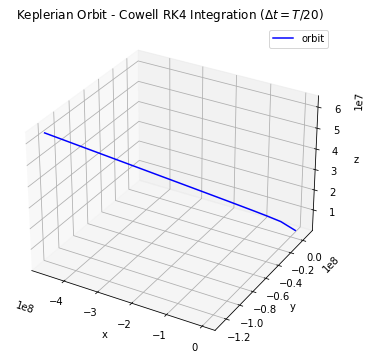

In [6]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x[0][:], x[1][:], x[2][:], 'blue', label="orbit")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Cowell RK4 Integration ($\Delta t=T/20$)")


plt.show()

The results are horrible because the timestep is too big.


If we plot with $dt = T/400$, here's what we get:


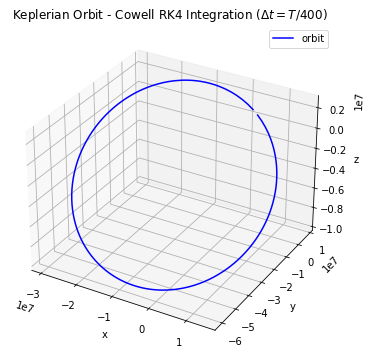

In [7]:
f = lambda t, X: X_ddot(t, X)

x0 = np.concatenate((x_vec, v_vec))
t0 = 0
tf = T
dt = delta_t/20

x2, t2 = RK4(f, x0, tf, dt, t0)

fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x2[0][:], x2[1][:], x2[2][:], 'blue', label="orbit")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Cowell RK4 Integration ($\Delta t=T/400$)")


plt.show()

## Sundman Transformation

Using the time transformation  $dt = r ds$ , integrate the keplerian orbit for an orbital period using a Runge-Kutta 4 of fixed step $\Delta t = T / 20 $, where T is the orbital period.

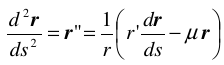


In [8]:
def new_RK4(f, x0, sf, ds, s0=0):
    # Time vector
    s = np.arange(s0, sf, ds)
    ns = s.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, ns))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(ns-1):
        # At the kth time step, each parameter k_n is computed
        k1 = ds*f(s[k], x[:, k])
        k2 = ds*f(s[k] + ds/2, x[:, k] + k1/2)
        k3 = ds*f(s[k] + ds/2, x[:, k] + k2/2)
        k4 = ds*f(s[k] + ds, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        #dx = dx/np.linalg.norm(dx[:3])
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x


In [9]:
def r_ddot(s, r):
    '''
    Returns the derivative of the state vector r, which now includes the time t
    ----------
    Arguments:
        s {float} -- modified time
        r {np.array} -- state vector=(x, y, z, vx, vy, vz, t)
    ----------
    Returns:
        (7,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot, tdot)
    '''
    
    r_dot = r[3:6] # dr/ds = v
    r_double_dot = (np.dot(r[:3],r[3:6].T)/np.linalg.norm(r[:3])*r_dot-mu*r[:3])/np.linalg.norm(r[:3]) # the acceleration defined above
    t_dot = np.linalg.norm(r[:3]) #dt/ds = |r|
    r_dot_dot = np.concatenate((r_dot, r_double_dot, t_dot), axis=None)
    
    return r_dot_dot

$$s = 2 π ( a / μ )^{1 / 2}$$


In [10]:
r_0 = x_vec
r_dot_0 = np.linalg.norm(x_vec)*v_vec #dr/ds = |r|*dr/dt

t0 = np.array([0])

f = lambda s, r: r_ddot(s, r)

r0 = np.concatenate((r_0, r_dot_0))
r0 = np.concatenate((r0, t0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

r = new_RK4(f, r0, sf, ds, s0)

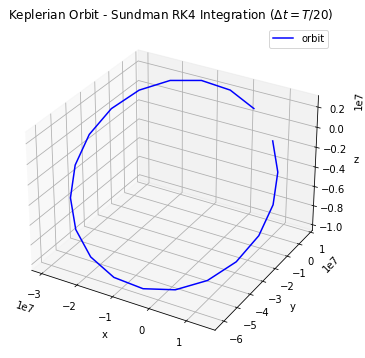

In [11]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(r[0][:], r[1][:], r[2][:], 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Sundman RK4 Integration ($\Delta t=T/20$)")


plt.show()

Let's try it again for a smaller step size:

In [12]:
r_0 = x_vec
r_dot_0 = np.linalg.norm(x_vec)*v_vec #dr/ds = |r|*dr/dt

t0 = np.array([0])

f = lambda s, r: r_ddot(s, r)

r0 = np.concatenate((r_0, r_dot_0))
r0 = np.concatenate((r0, t0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/400

r2 = new_RK4(f, r0, sf, ds, s0)

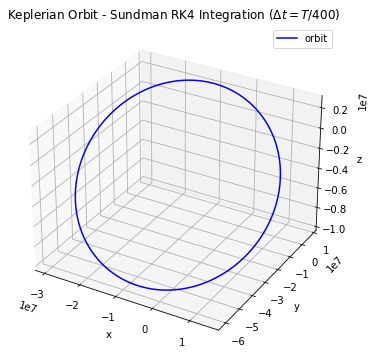

In [13]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(r2[0][:], r2[1][:], r2[2][:], 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Sundman RK4 Integration ($\Delta t = T/400$)")


plt.show()

## Comparison

Compare both solutions. Which is more precise?

To compare, you'll have to transform the solution for position and velocity.

First we need to obtain the real velocity for both solutions of the Sundman transformation:

In [14]:
for i in range(r[:3,:].shape[1]):
    r[3:6, i] /= np.linalg.norm(r[:3,i])
    
for i in range(r2[:3,:].shape[1]):
    r2[3:6, i] /= np.linalg.norm(r2[:3,i])

In [88]:
data = pd.DataFrame({'x':[x_vec[0], x[0][-1], x2[0][-1], r[0][-1], r2[0][-1]], \
                    'y':[x_vec[1], x[1][-1], x2[1][-1], r[1][-1], r2[1][-1]], \
                    'z':[x_vec[2], x[2][-1], x2[2][-1], r[2][-1], r2[2][-1]], \
                    'vx':[v_vec[0], x[3][-1], x2[3][-1], r[3][-1], r2[3][-1]], \
                    'vy':[v_vec[1], x[4][-1], x2[4][-1], r[4][-1], r2[4][-1]], \
                    'vz':[v_vec[2], x[5][-1], x2[5][-1], r[5][-1], r2[5][-1]]},
        index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)'])

In [89]:
data

,x,y,z,vx,vy,vz
Real,1.888980e+06,6.652210e+06,9.024829e+05,-9585.795111,2413.570512,2273.504097
Cowell (T/20),-4.638509e+08,-1.262776e+08,6.395957e+07,-7248.487971,-2126.445043,970.466769
Cowell (T/400),3.305771e+06,6.200632e+06,5.484857e+05,-9129.097049,3545.163240,2401.375506
Sundman (T/20),8.671042e+06,2.312787e+06,-1.204690e+06,-5532.555506,6414.378349,2263.569919
Sundman (T/400),2.198391e+06,6.569907e+06,8.282654e+05,-9507.994022,2665.252035,2306.448996


In [90]:
errors = pd.DataFrame({'x':[0.0, abs(x[0][-1]-x_vec[0])/x_vec[0], abs(x2[0][-1]-x_vec[0])/x_vec[0], abs(r[0][-1]-x_vec[0])/x_vec[0], abs(r2[0][-1]-x_vec[0])/x_vec[0]], \
                    'y':[0.0, abs(x[1][-1]-x_vec[1])/x_vec[1], abs(x2[1][-1]-x_vec[1])/x_vec[1], abs(r[1][-1]-x_vec[1])/x_vec[1], abs(r2[1][-1]-x_vec[1])/x_vec[1]], \
                    'z':[0.0, abs(x[2][-1]-x_vec[2])/x_vec[2], abs(x2[2][-1]-x_vec[2])/x_vec[2], abs(r[2][-1]-x_vec[2])/x_vec[2], abs(r2[2][-1]-x_vec[2])/x_vec[2]], \
                    'vx':[0.0, abs(x[3][-1]-v_vec[0])/v_vec[0], abs(x2[3][-1]-v_vec[0])/v_vec[0], abs(r[3][-1]-v_vec[0])/v_vec[0], abs(r2[3][-1]-v_vec[0])/v_vec[0]], \
                    'vy':[0.0, abs(x[4][-1]-v_vec[1])/v_vec[1], abs(x2[4][-1]-v_vec[1])/v_vec[1], abs(r[4][-1]-v_vec[1])/v_vec[1], abs(r2[4][-1]-v_vec[1])/v_vec[1]], \
                    'vz':[0.0, abs(x[5][-1]-v_vec[2])/v_vec[2], abs(x2[5][-1]-v_vec[2])/v_vec[2], abs(r[5][-1]-v_vec[2])/v_vec[2], abs(r2[5][-1]-v_vec[2])/v_vec[2]]},
        index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)'])

In [91]:
errors

,x,y,z,vx,vy,vz
Real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cowell (T/20),246.556279,19.982808,69.870673,-0.243830,1.881037,0.573141
Cowell (T/400),0.750029,0.067884,0.392248,-0.047643,0.468846,0.056244
Sundman (T/20),3.590330,0.652328,2.334862,-0.422838,1.657630,0.004370
Sundman (T/400),0.163798,0.012372,0.082237,-0.008116,0.104278,0.014491


Here's what we get for the errors visually:

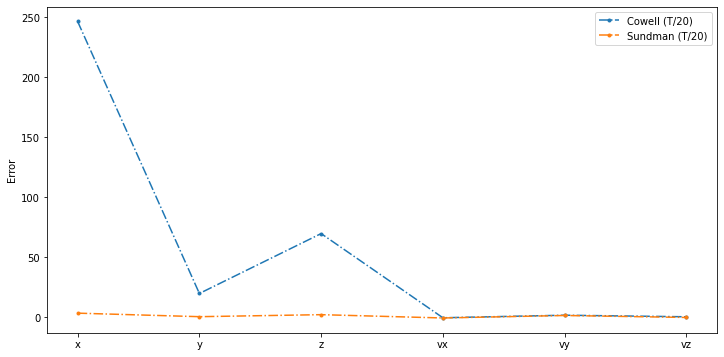

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(errors.loc['Cowell (T/20)'], linestyle='-.', marker='.', label='Cowell (T/20)')
#plt.plot(errors.loc['Cowell (T/400)'], linestyle='-.', marker='.', label='Cowell (T/400)')
plt.plot(errors.loc['Sundman (T/20)'], linestyle='-.', marker='.', label='Sundman (T/20)')
#plt.plot(errors.loc['Sundman (T/400)'], linestyle='-.', marker='.', label='Sundman (T/400)')
plt.ylabel("Error")
plt.legend()
plt.show()

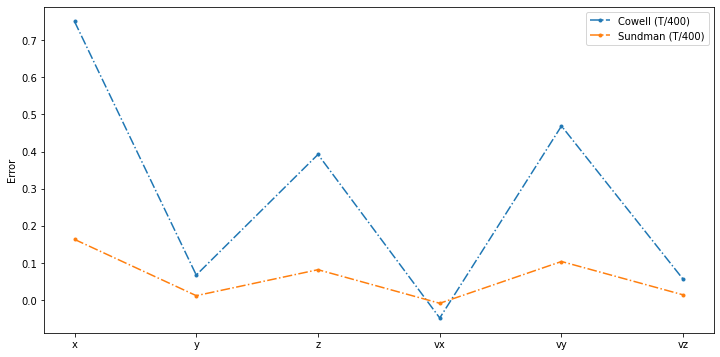

In [93]:
plt.figure(figsize=(12, 6))
#plt.plot(errors.loc['Cowell (T/20)'], linestyle='-.', marker='.', label='Cowell (T/20)')
plt.plot(errors.loc['Cowell (T/400)'], linestyle='-.', marker='.', label='Cowell (T/400)')
#plt.plot(errors.loc['Sundman (T/20)'], linestyle='-.', marker='.', label='Sundman (T/20)')
plt.plot(errors.loc['Sundman (T/400)'], linestyle='-.', marker='.', label='Sundman (T/400)')
plt.ylabel("Error")
plt.legend()
plt.show()

It is conspicuous that the errors for the Sundman transformation are a lot smaller!

# List 2

Considering the transformation in time $dt = r ds$, but with the ODEs for the stabilized system, integrate the keplerian orbit using a Runge-Kutta 4 of fixed step $\Delta t = T / 20 $, where T is the orbital period.

Compare with the previous solutions.

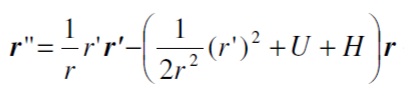

In [21]:
def r_ddot_stabilized(s, r):
    '''
    Returns the derivative of the state vector r, which now includes the time t and negative of energy H
    ----------
    Arguments:
        s {float} -- modified time
        r {np.array} -- state vector=(x, y, z, vx, vy, vz, t, H)
    ----------
    Returns:
        (8,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot, tdot, Hdot)
    '''
    mod_r = np.linalg.norm(r[:3])
    mod_r_dot = np.dot(r[:3],r[3:6])/mod_r
    
    r_dot = r[3:6] # dr/ds = v
    r_double_dot = mod_r_dot*r_dot/mod_r - r[:3]*(np.linalg.norm(r[3:6])**2/(2*mod_r**2) + r[7]) # the acceleration defined above
    t_dot = np.array([mod_r]) #dt/ds = |r|
    H_dot = np.array([0]) # dH/ds = 0
        
    r_dot_dot = np.concatenate((r_dot, r_double_dot, t_dot, H_dot), axis=None) # State vector is the concatenation of all the above
    
    return r_dot_dot

## Stabilized (T/20)

Below, we compute the final state vector `(x, y, z, vx, vy, vz, t, H)` using the RK4 integration and the `r_ddot_stabilized` function:

In [22]:
r_0 = x_vec
r_dot_0 = np.linalg.norm(x_vec)*v_vec #dr/ds = |r|*dr/dt
t_0 = np.array([0]) # t_0 = 0
H_0 = np.array([mu/(2*a)]) # H is the negative of -mu/(2a)

f = lambda s, r: r_ddot_stabilized(s, r)

r0 = np.concatenate((r_0, r_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

r3 = new_RK4(f, r0, sf, ds, s0)

The following cell integrates forwards in time in order to reach a value close to the real period of the orbit, so that it can correct the computational error intrinsic to the integration above:

In [23]:
r_0 = r3[:3,-1]
r_dot_0 = r3[3:6,-1]
t_0 = np.array([r3[6,-1]])
H_0 = np.array([r3[7,-1]])

f = lambda s, r: r_ddot_stabilized(s, r)

r02 = np.concatenate((r_0, r_dot_0, t_0, H_0))
s02 = 2*np.pi*(a/mu)**.5
i = 4
r_corrected = r3

# we calculate myriad values for r (r_corrected) and compare their time (r_corrected[6,-1]) to the real period (T):
while abs(T - r_corrected[6,-1]) > 1e-1:
    sf2 = (T - r3[6,-1])/T*sf*i + sf
    ds2 = (sf2 - s02)/20
    r_corrected = new_RK4(f, r02, sf2, ds2, s02)
    i += 0.001

In [24]:
print(f"The corrected time is now: {r_corrected[6,-1]} s \nwhile the real period is {T} s")

The corrected time is now: 64799.9649689429 s 
while the real period is 64799.99724879846 s


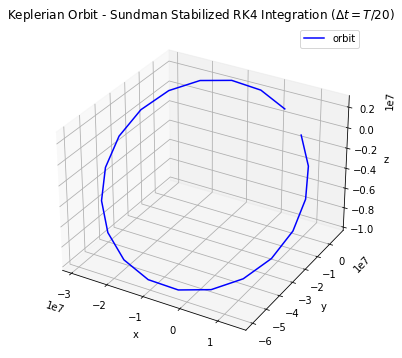

In [25]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(r3[0][:], r3[1][:], r3[2][:], 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Sundman Stabilized RK4 Integration ($\Delta t=T/20$)")


plt.show()

PS. It was chosen not to show the final steps, that's why the orbit doesn't complete a full period. If we were to concatenate the original `r3` state vector with the corrected `r_corrected` state vector, the latter would yield a much more refined arc, since it also has 20 timesteps but for a shorter length of the arc.

## Stabilized (T/400)

Once again for a smaller timestep:

In [26]:
r_0 = x_vec
r_dot_0 = np.linalg.norm(x_vec)*v_vec #dr/ds = |r|*dr/dt
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, r: r_ddot_stabilized(s, r)

r0 = np.concatenate((r_0, r_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/400

r4 = new_RK4(f, r0, sf, ds, s0)

In [27]:
r_0 = r4[:3,-1]
r_dot_0 = r4[3:6,-1]
t_0 = np.array([r4[6,-1]])
H_0 = np.array([r4[7,-1]])

f = lambda s, r: r_ddot_stabilized(s, r)

r03 = np.concatenate((r_0, r_dot_0, t_0, H_0))
s03 = 2*np.pi*(a/mu)**.5
i = 4
r_corrected2 = r4

# we calculate myriad values for r (r_corrected2) and compare their time (r_corrected2[6,-1]) to the real period (T):
while abs(T - r_corrected2[6,-1]) > 1e-2:
    sf3 = (T - r4[6,-1])/T*sf*i + sf
    ds2 = (sf3 - s03)/20
    r_corrected2 = new_RK4(f, r03, sf3, ds2, s03)
    i += 0.001

In [28]:
print(f"The corrected time is now: {r_corrected2[6,-1]} s \nwhile the real period is {T} s")

The corrected time is now: 64799.98929246395 s 
while the real period is 64799.99724879846 s


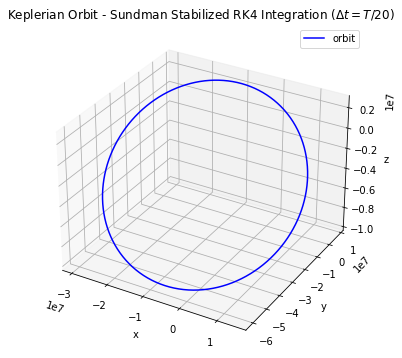

In [29]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(r4[0][:], r4[1][:], r4[2][:], 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Sundman Stabilized RK4 Integration ($\Delta t=T/20$)")


plt.show()

Below is only the correction for the final velocity:

In [30]:
for i in range(r4[:3,:].shape[1]):
    r4[3:6, i] /= np.linalg.norm(r4[:3,i])
for i in range(r3[:3,:].shape[1]):
    r3[3:6, i] /= np.linalg.norm(r3[:3,i])
for i in range(r_corrected[:3,:].shape[1]):
    r_corrected[3:6, i] /= np.linalg.norm(r_corrected[:3,i])
for i in range(r_corrected2[:3,:].shape[1]):
    r_corrected2[3:6, i] /= np.linalg.norm(r_corrected2[:3,i])

## Comparison

Now, we can have our data for all the methods so far:

In [31]:
data = pd.DataFrame({'x':[x_vec[0], x[0][-1], x2[0][-1], r[0][-1], r2[0][-1], r_corrected[0][-1], r_corrected2[0][-1]], \
                    'y':[x_vec[1], x[1][-1], x2[1][-1], r[1][-1], r2[1][-1], r_corrected[1][-1], r_corrected2[1][-1]], \
                    'z':[x_vec[2], x[2][-1], x2[2][-1], r[2][-1], r2[2][-1], r_corrected[2][-1], r_corrected2[2][-1]], \
                    'vx':[v_vec[0], x[3][-1], x2[3][-1], r[3][-1], r2[3][-1], r_corrected[3][-1], r_corrected2[3][-1]], \
                    'vy':[v_vec[1], x[4][-1], x2[4][-1], r[4][-1], r2[4][-1], r_corrected[4][-1], r_corrected2[4][-1]], \
                    'vz':[v_vec[2], x[5][-1], x2[5][-1], r[5][-1], r2[5][-1], r_corrected[5][-1], r_corrected2[5][-1]]},
        index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)', 'Stabilized (T/20)', 'Stabilized (T/400)'])

In [32]:
data

,x,y,z,vx,vy,vz
Real,1.888980e+06,6.652210e+06,9.024829e+05,-9585.795111,2413.570512,2273.504097
Cowell (T/20),-4.638509e+08,-1.262776e+08,6.395957e+07,-7248.487971,-2126.445043,970.466769
Cowell (T/400),3.305771e+06,6.200632e+06,5.484857e+05,-9129.097049,3545.163240,2401.375506
Sundman (T/20),8.671042e+06,2.312787e+06,-1.204690e+06,-5532.555506,6414.378349,2263.569919
Sundman (T/400),2.198391e+06,6.569907e+06,8.282654e+05,-9507.994022,2665.252035,2306.448996
Stabilized (T/20),3.176144e+06,6.253333e+06,5.830310e+05,-9184.228592,3456.751993,2395.070044
Stabilized (T/400),1.889064e+06,6.652189e+06,9.024629e+05,-9585.775645,2413.639064,2273.513397


Now, for the errors in the data above:

In [33]:
errors = pd.DataFrame({'x':[x_vec[0], abs(x[0][-1]-x_vec[0])/x_vec[0], abs(x2[0][-1]-x_vec[0])/x_vec[0], abs(r[0][-1]-x_vec[0])/x_vec[0], abs(r2[0][-1]-x_vec[0])/x_vec[0], abs(r_corrected[0][-1]-x_vec[0])/x_vec[0], abs(r_corrected2[0][-1]-x_vec[0])/x_vec[0]], \
                    'y':[x_vec[1], abs(x[1][-1]-x_vec[1])/x_vec[1], abs(x2[1][-1]-x_vec[1])/x_vec[1], abs(r[1][-1]-x_vec[1])/x_vec[1], abs(r2[1][-1]-x_vec[1])/x_vec[1], abs(r_corrected[1][-1]-x_vec[1])/x_vec[1], abs(r_corrected2[1][-1]-x_vec[1])/x_vec[1]], \
                    'z':[x_vec[2], abs(x[2][-1]-x_vec[2])/x_vec[2], abs(x2[2][-1]-x_vec[2])/x_vec[2], abs(r[2][-1]-x_vec[2])/x_vec[2], abs(r2[2][-1]-x_vec[2])/x_vec[2], abs(r_corrected[2][-1]-x_vec[2])/x_vec[2], abs(r_corrected2[2][-1]-x_vec[2])/x_vec[2]], \
                    'vx':[v_vec[0], abs(x[3][-1]-v_vec[0])/abs(v_vec[0]), abs(x2[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r2[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r_corrected[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r_corrected2[3][-1]-v_vec[0])/abs(v_vec[0])], \
                    'vy':[v_vec[1], abs(x[4][-1]-v_vec[1])/v_vec[1], abs(x2[4][-1]-v_vec[1])/v_vec[1], abs(r[4][-1]-v_vec[1])/v_vec[1], abs(r2[4][-1]-v_vec[1])/v_vec[1], abs(r_corrected[4][-1]-v_vec[1])/v_vec[1], abs(r_corrected2[4][-1]-v_vec[1])/v_vec[1]], \
                    'vz':[v_vec[2], abs(x[5][-1]-v_vec[2])/v_vec[2], abs(x2[5][-1]-v_vec[2])/v_vec[2], abs(r[5][-1]-v_vec[2])/v_vec[2], abs(r2[5][-1]-v_vec[2])/v_vec[2], abs(r_corrected[5][-1]-v_vec[2])/v_vec[2], abs(r_corrected2[5][-1]-v_vec[2])/v_vec[2]]},
            index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)', 'Stabilized (T/20)', 'Stabilized (T/400)'])

In [34]:
errors

,x,y,z,vx,vy,vz
Real,1.888980e+06,6.652210e+06,902482.883545,-9585.795111,2413.570512,2273.504097
Cowell (T/20),2.465563e+02,1.998281e+01,69.870673,0.243830,1.881037,0.573141
Cowell (T/400),7.500294e-01,6.788381e-02,0.392248,0.047643,0.468846,0.056244
Sundman (T/20),3.590330e+00,6.523280e-01,2.334862,0.422838,1.657630,0.004370
Sundman (T/400),1.637980e-01,1.237220e-02,0.082237,0.008116,0.104278,0.014491
Stabilized (T/20),6.814067e-01,5.996154e-02,0.353970,0.041892,0.432215,0.053471
Stabilized (T/400),4.449431e-05,3.181409e-06,0.000022,0.000002,0.000028,0.000004


Visualizing the errors for the best models (Sundman and Stabilized):

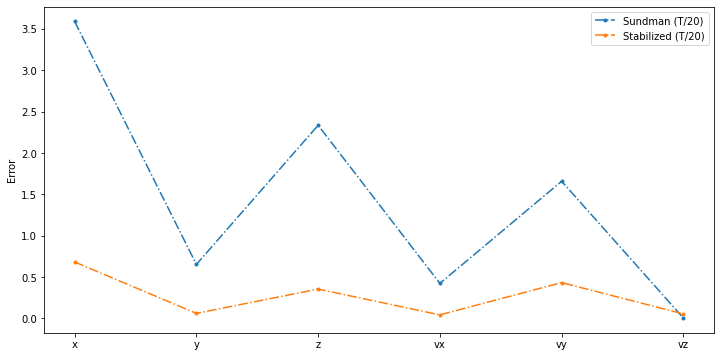

In [35]:
plt.figure(figsize=(12, 6))
#plt.plot(errors.loc['Cowell (T/20)'], linestyle='-.', marker='.', label='Cowell (T/20)')
#plt.plot(errors.loc['Cowell (T/400)'], linestyle='-.', marker='.', label='Cowell (T/400)')
plt.plot(errors.loc['Sundman (T/20)'], linestyle='-.', marker='.', label='Sundman (T/20)')
#plt.plot(errors.loc['Sundman (T/400)'], linestyle='-.', marker='.', label='Sundman (T/400)')
plt.plot(errors.loc['Stabilized (T/20)'], linestyle='-.', marker='.', label='Stabilized (T/20)')
plt.ylabel("Error")
plt.legend()
plt.show()

Doing the same for the errors for the T/400 timesteps:

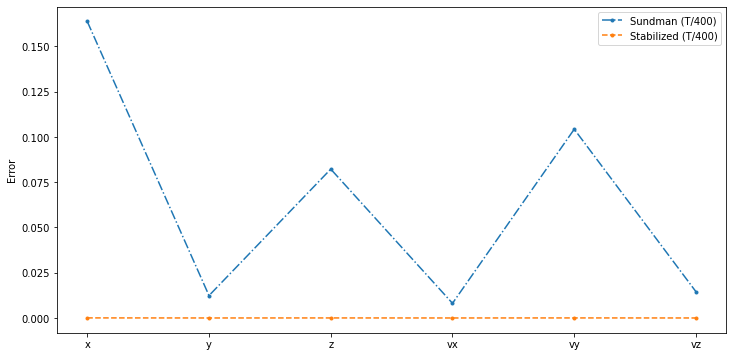

In [36]:
plt.figure(figsize=(12, 6))
#plt.plot(errors.loc['Cowell (T/20)'], linestyle='-.', marker='.', label='Cowell (T/20)')
#plt.plot(errors.loc['Cowell (T/400)'], linestyle='-.', marker='.', label='Cowell (T/400)')
#plt.plot(errors.loc['Sundman (T/20)'], linestyle='-.', marker='.', label='Sundman (T/20)')
plt.plot(errors.loc['Sundman (T/400)'], linestyle='-.', marker='.', label='Sundman (T/400)')
plt.plot(errors.loc['Stabilized (T/400)'], linestyle='--', marker='.', label='Stabilized (T/400)')
plt.ylabel("Error")
plt.legend()
plt.show()

# Lista 3 - computador

Using the regularized method, integrate the keplerian orbit for an orbital period using a Runge-Kutta 4 of fixed step $\Delta t = T / 20 $, where T is the orbital period.

After that, integrate the orbit for an orbital period using an Adams-Bashford-Molton 4 integrator.

## RK4 Regularized (T/20)

Initial conditions:

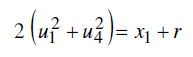

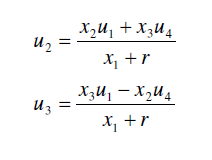

Choosing $u_1$ as 0:

In [37]:
# initial conditions
r_0 = x_vec
r_dot_0 = np.linalg.norm(x_vec)*v_vec #dr/ds = |r|*dr/dt
r_mod_0 = np.linalg.norm(r_0)

# initial vector u
u_1 = 0
u_4 = np.sqrt((r_0[0] + r_mod_0)/2 - u_1**2)
u_2 = (r_0[1]*u_1 + r_0[2]*u_4)/(r_0[0] + r_mod_0)
u_3 = (r_0[2]*u_1 - r_0[1]*u_4)/(r_0[0] + r_mod_0)

u_vec = np.array([u_1, u_2, u_3, u_4])

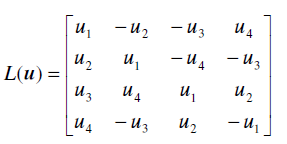

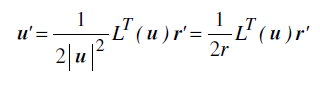

In [38]:
L = np.array([[u_1, -u_2, -u_3, u_4],
              [u_2, u_1, -u_4, -u_3],
              [u_3, u_4, u_1, u_2],
              [u_4, -u_3, u_2, -u_1]])

u_dot = L.T@np.concatenate((r_dot_0, np.array([0]))).T/(2*r_mod_0)

Integrating:

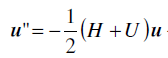

In [60]:
def u_ddot_regularized(s, u):
    '''
    Returns the derivative of the state vector u, which now includes the time t and negative of energy H
    ----------
    Arguments:
        s {float} -- modified time
        u {np.array} -- state vector = (u_1, u_2, u_3, u_4, u_dot_1, u_dot_2, u_dot_3, u_dot_4, t, H)
    ----------
    Returns:
        (10,1) np.array -- (u_dot_1, u_dot_2, u_dot_3, u_dot_4, u_dot_dot_1, u_dot_dot_2, u_dot_dot_3, u_dot_dot_4, tdot, Hdot)
    '''
    
    mod_r = np.linalg.norm(u[:4])**2
    
    u_dot = u[4:8] # u_dot = u_dot
    u_double_dot = -1/2*(u[-1])*u[:4] # the acceleration defined above
    t_dot = np.array([mod_r]) # dt/ds = |r|
    H_dot = np.array([0]) # H'=0
        
    u_dot_dot = np.concatenate((u_dot, u_double_dot, t_dot, H_dot), axis=None)
    
    return u_dot_dot

In [61]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

u = new_RK4(f, u0, sf, ds, s0)

Let's transform it back to r:

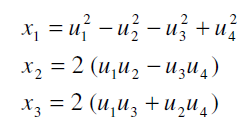

In [62]:
x_1 = u[0, :]**2 - u[1, :]**2 - u[2, :]**2 + u[3, :]**2
x_2 = 2*(u[0, :]*u[1, :] - u[2, :]*u[3, :])
x_3 = 2*(u[0, :]*u[2, :] + u[1, :]*u[3, :])

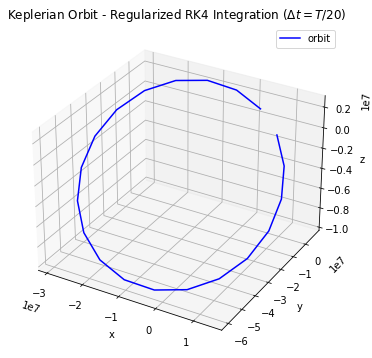

In [63]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x_1, x_2, x_3, 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Regularized RK4 Integration ($\Delta t=T/20$)")


plt.show()

Let's correct for the time:

In [64]:
u_0 = u[:4, -1]
u_dot_0 = u[4:8, -1]
t_0 = np.array([u[8, -1]])
H_0 = np.array([u[9, -1]])


def f(s, u): return u_ddot_regularized(s, u)


u02 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s02 = 2*np.pi*(a/mu)**.5
i = 0.05

u_corrected2 = u

# we calculate myriad values foru (r_corrected2) and compare their time (r_corrected2[6,-1]) to theueal period (T):
while abs(T - u_corrected2[8, -1]) > 1e-2:
    sf2 = s02*i + s02
    ds2 = (sf2 - s02)/20
    u_corrected2 = new_RK4(f, u02, sf2, ds2, s02)
    if (T - u_corrected2[8, -1]) > 0: # time forward
        i += 1e-6
    else: # time backward
        i -= 1e-6
        
print(f"The corrected time is now: {u_corrected2[8,-1]} s \nwhile the real period is: {T} s")

Now, calculating the position and velocity vectors from the corrected final values:

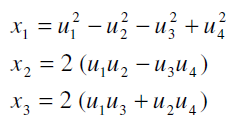

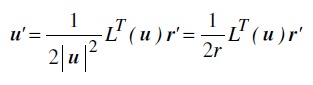

In [66]:
x_1_corrected = u_corrected2[0, :]**2 - u_corrected2[1, :]**2 - u_corrected2[2, :]**2 + u_corrected2[3, :]**2
x_2_corrected = 2*(u_corrected2[0, :]*u_corrected2[1, :] - u_corrected2[2, :]*u_corrected2[3, :])
x_3_corrected = 2*(u_corrected2[0, :]*u_corrected2[2, :] + u_corrected2[1, :]*u_corrected2[3, :])

x_corrected = np.array([x_1_corrected, x_2_corrected, x_3_corrected])

L = np.array([[u_corrected2[0, -1], -u_corrected2[1, -1], -u_corrected2[2, -1], u_corrected2[3, -1]],
              [u_corrected2[1, -1], u_corrected2[0, -1], -u_corrected2[3, -1], -u_corrected2[2, -1]],
              [u_corrected2[2, -1], u_corrected2[3, -1], u_corrected2[0, -1], u_corrected2[1, -1]],
              [u_corrected2[3, -1], -u_corrected2[2, -1], u_corrected2[1, -1], -u_corrected2[0, -1]]])

x_dot_corrected = np.linalg.inv(L.T)@u_corrected2[4:8, -1]*2*np.linalg.norm(x_corrected[:, -1])
x_dot_corrected/= np.linalg.norm(x_corrected[:,-1])

The data calculated above will be used in the "Comparison" section.

## PC4 Regularized

Let's do the same using the predictor-corrector algorithm of Adams-Bashfort-Moulton (order 4):

**Predictor** (Adams-Bashford):
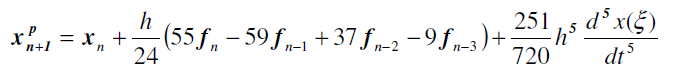

**Corrector** (Adams-Moulton):
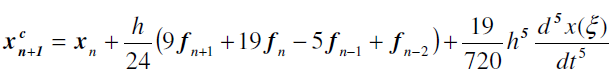

In the latter, $f_{n+1}$ is obtained from $x_{n+1}^p$:
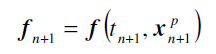

In [54]:
def ABM(f, x0, sf, ds, s0=0):
    # Time vector
    s = np.arange(s0, sf, ds)
    ns = s.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, ns))
    
    # Initial conditions
    x[:,0] = x0
    
    # First we initialize with an RK4:
    for k in range(0, 3):
        # At the kth time step, each parameter k_n is computed
        k1 = ds*f(s[k], x[:, k])
        k2 = ds*f(s[k] + ds/2, x[:, k] + k1/2)
        k3 = ds*f(s[k] + ds/2, x[:, k] + k2/2)
        k4 = ds*f(s[k] + ds, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
    
    # Proceeding to the ABM integration:
    for k in range(3, ns-1):
        f_m3 = f(s[k-3], x[:, k-3]) #f_{n-3}
        f_m2 = f(s[k-2], x[:, k-2]) #f_{n-2}
        f_m1 = f(s[k-1], x[:, k-1]) #f_{n-1}
        f_0 = f(s[k], x[:, k]) #f_{n}
        
        ### Predictor ###
        dx = (ds/24) * (55*f_0 - 59*f_m1 + 37*f_m2 - 9*f_m3)
        x[:, k+1] = x[:, k] + dx
        
        f_p1 = f(s[k+1], x[:, k+1]) #f_{n+1}
        
        ### Corrector ###
        dx = (ds/24) * (9*f_p1 + 19*f_0 - 5*f_m1 + f_m2)
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x

Integrating for our conditions:

In [79]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

u_pc = ABM(f, u0, sf, ds, s0)

Let's transform it back to r:

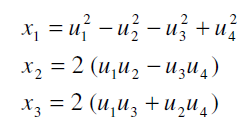

In [71]:
x_pc_1 = u_pc[0, :]**2 - u_pc[1, :]**2 - u_pc[2, :]**2 + u_pc[3, :]**2
x_pc_2 = 2*(u_pc[0, :]*u_pc[1, :] - u_pc[2, :]*u_pc[3, :])
x_pc_3 = 2*(u_pc[0, :]*u_pc[2, :] + u_pc[1, :]*u_pc[3, :])

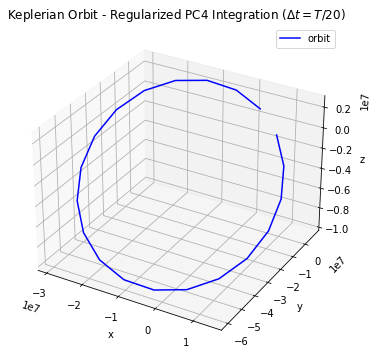

In [72]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x_pc_1, x_pc_2, x_pc_3, 'blue', label="orbit")

ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Regularized PC4 Integration ($\Delta t=T/20$)")


plt.show()

Let's correct for the time:

In [73]:
u_0 = u_pc[:4, -1]
u_dot_0 = u_pc[4:8, -1]
t_0 = np.array([u_pc[8, -1]])
H_0 = np.array([u_pc[9, -1]])


def f(s, u): return u_ddot_regularized(s, u)


u_pc02 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s02 = 2*np.pi*(a/mu)**.5
i = 0.05

u_pc_corrected2 = u_pc

# we calculate myriad values foru (r_corrected2) and compare their time (r_corrected2[6,-1]) to theueal period (T):
while abs(T - u_pc_corrected2[8, -1]) > 1e-2:
    sf2 = s02*i + s02
    ds2 = (sf2 - s02)/20
    u_pc_corrected2 = ABM(f, u_pc02, sf2, ds2, s02)
    if (T - u_pc_corrected2[8, -1]) > 0: # time forward
        i += 1e-6
    else: # time backward
        i -= 1e-6
        
print(f"The corrected time is now: {u_pc_corrected2[8,-1]} s \nwhile the real period is: {T} s")

The corrected time is now: 64799.99293757867 s 
while the real period is: 64799.99724879846 s


Calculating the position and velocity vectors from the corrected final values:


In [74]:
x_pc_1_corrected = u_pc_corrected2[0, :]**2 - u_pc_corrected2[1, :]**2 - u_pc_corrected2[2, :]**2 + u_pc_corrected2[3, :]**2
x_pc_2_corrected = 2*(u_pc_corrected2[0, :]*u_pc_corrected2[1, :] - u_pc_corrected2[2, :]*u_pc_corrected2[3, :])
x_pc_3_corrected = 2*(u_pc_corrected2[0, :]*u_pc_corrected2[2, :] + u_pc_corrected2[1, :]*u_pc_corrected2[3, :])

x_pc_corrected = np.array([x_pc_1_corrected, x_pc_2_corrected, x_pc_3_corrected])

L_pc = np.array([[u_pc_corrected2[0, -1], -u_pc_corrected2[1, -1], -u_pc_corrected2[2, -1], u_pc_corrected2[3, -1]],
              [u_pc_corrected2[1, -1], u_pc_corrected2[0, -1], -u_pc_corrected2[3, -1], -u_pc_corrected2[2, -1]],
              [u_pc_corrected2[2, -1], u_pc_corrected2[3, -1], u_pc_corrected2[0, -1], u_pc_corrected2[1, -1]],
              [u_pc_corrected2[3, -1], -u_pc_corrected2[2, -1], u_pc_corrected2[1, -1], -u_pc_corrected2[0, -1]]])

x_pc_dot_corrected = np.linalg.inv(L_pc.T)@u_pc_corrected2[4:8, -1]*2*np.linalg.norm(x_pc_corrected[:, -1])
x_pc_dot_corrected/= np.linalg.norm(x_pc_corrected[:,-1])

## Comparison

In [86]:
data = pd.DataFrame({'x':[x_vec[0], x[0][-1], x2[0][-1], r[0][-1], r2[0][-1], r_corrected[0][-1], r_corrected2[0][-1], x_corrected[0, -1], x_pc_corrected[0, -1]], \
                    'y':[x_vec[1], x[1][-1], x2[1][-1], r[1][-1], r2[1][-1], r_corrected[1][-1], r_corrected2[1][-1], x_corrected[1, -1], x_pc_corrected[1, -1]], \
                    'z':[x_vec[2], x[2][-1], x2[2][-1], r[2][-1], r2[2][-1], r_corrected[2][-1], r_corrected2[2][-1], x_corrected[2, -1], x_pc_corrected[2, -1]], \
                    'vx':[v_vec[0], x[3][-1], x2[3][-1], r[3][-1], r2[3][-1], r_corrected[3][-1], r_corrected2[3][-1], x_dot_corrected[0], x_pc_dot_corrected[0]], \
                    'vy':[v_vec[1], x[4][-1], x2[4][-1], r[4][-1], r2[4][-1], r_corrected[4][-1], r_corrected2[4][-1], x_dot_corrected[1], x_pc_dot_corrected[1]], \
                    'vz':[v_vec[2], x[5][-1], x2[5][-1], r[5][-1], r2[5][-1], r_corrected[5][-1], r_corrected2[5][-1], x_dot_corrected[2], x_pc_dot_corrected[2]]},
        index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)', 'Stabilized (T/20)', 'Stabilized (T/400)', 'Regularized RK4 (T/20)', 'Regularized PC4 (T/20)'])
data

,x,y,z,vx,vy,vz
Real,1.888980e+06,6.652210e+06,9.024829e+05,-9585.795111,2413.570512,2273.504097
Cowell (T/20),-4.638509e+08,-1.262776e+08,6.395957e+07,-7248.487971,-2126.445043,970.466769
Cowell (T/400),3.305771e+06,6.200632e+06,5.484857e+05,-9129.097049,3545.163240,2401.375506
Sundman (T/20),8.671042e+06,2.312787e+06,-1.204690e+06,-5532.555506,6414.378349,2263.569919
Sundman (T/400),2.198391e+06,6.569907e+06,8.282654e+05,-9507.994022,2665.252035,2306.448996
Stabilized (T/20),3.176144e+06,6.253333e+06,5.830310e+05,-9184.228592,3456.751993,2395.070044
Stabilized (T/400),1.889064e+06,6.652189e+06,9.024629e+05,-9585.775645,2413.639064,2273.513397
Regularized RK4 (T/20),1.883615e+06,6.653531e+06,9.037497e+05,-9587.034026,2409.200925,2272.910933
Regularized PC4 (T/20),1.919707e+06,6.644956e+06,8.952868e+05,-9578.651879,2438.509491,2276.875834


In [85]:
errors = pd.DataFrame({'x':[x_vec[0], abs(x[0][-1]-x_vec[0])/x_vec[0], abs(x2[0][-1]-x_vec[0])/x_vec[0], abs(r[0][-1]-x_vec[0])/x_vec[0], abs(r2[0][-1]-x_vec[0])/x_vec[0], abs(r_corrected[0][-1]-x_vec[0])/x_vec[0], abs(r_corrected2[0][-1]-x_vec[0])/x_vec[0], abs(x_corrected[0, -1] - x_vec[0])/x_vec[0], abs(x_pc_corrected[0, -1] - x_vec[0])/x_vec[0]], \
                    'y':[x_vec[1], abs(x[1][-1]-x_vec[1])/x_vec[1], abs(x2[1][-1]-x_vec[1])/x_vec[1], abs(r[1][-1]-x_vec[1])/x_vec[1], abs(r2[1][-1]-x_vec[1])/x_vec[1], abs(r_corrected[1][-1]-x_vec[1])/x_vec[1], abs(r_corrected2[1][-1]-x_vec[1])/x_vec[1], abs(x_corrected[1, -1] - x_vec[1])/x_vec[1], abs(x_pc_corrected[1, -1] - x_vec[1])/x_vec[1]], \
                    'z':[x_vec[2], abs(x[2][-1]-x_vec[2])/x_vec[2], abs(x2[2][-1]-x_vec[2])/x_vec[2], abs(r[2][-1]-x_vec[2])/x_vec[2], abs(r2[2][-1]-x_vec[2])/x_vec[2], abs(r_corrected[2][-1]-x_vec[2])/x_vec[2], abs(r_corrected2[2][-1]-x_vec[2])/x_vec[2], abs(x_corrected[2, -1] - x_vec[2])/x_vec[2], abs(x_pc_corrected[2, -1] - x_vec[2])/x_vec[2]], \
                    'vx':[v_vec[0], abs(x[3][-1]-v_vec[0])/abs(v_vec[0]), abs(x2[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r2[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r_corrected[3][-1]-v_vec[0])/abs(v_vec[0]), abs(r_corrected2[3][-1]-v_vec[0])/v_vec[0], abs(x_dot_corrected[0] - v_vec[0])/v_vec[0], abs(x_pc_dot_corrected[0] - v_vec[0])/v_vec[0]], \
                    'vy':[v_vec[1], abs(x[4][-1]-v_vec[1])/v_vec[1], abs(x2[4][-1]-v_vec[1])/v_vec[1], abs(r[4][-1]-v_vec[1])/v_vec[1], abs(r2[4][-1]-v_vec[1])/v_vec[1], abs(r_corrected[4][-1]-v_vec[1])/v_vec[1], abs(r_corrected2[4][-1]-v_vec[1])/v_vec[1], abs(x_dot_corrected[1] - v_vec[1])/v_vec[1], abs(x_pc_dot_corrected[1] - v_vec[1])/v_vec[1]], \
                    'vz':[v_vec[2], abs(x[5][-1]-v_vec[2])/v_vec[2], abs(x2[5][-1]-v_vec[2])/v_vec[2], abs(r[5][-1]-v_vec[2])/v_vec[2], abs(r2[5][-1]-v_vec[2])/v_vec[2], abs(r_corrected[5][-1]-v_vec[2])/v_vec[2], abs(r_corrected2[5][-1]-v_vec[2])/v_vec[2], abs(x_dot_corrected[2] - v_vec[2])/v_vec[2], abs(x_pc_dot_corrected[2] - v_vec[2])/v_vec[2]]},
            index=['Real', 'Cowell (T/20)', 'Cowell (T/400)', 'Sundman (T/20)', 'Sundman (T/400)', 'Stabilized (T/20)', 'Stabilized (T/400)', 'Regularized RK4 (T/20)', 'Regularized PC4 (T/20)'])
errors

,x,y,z,vx,vy,vz
Real,1.888980e+06,6.652210e+06,902482.883545,-9585.795111,2413.570512,2273.504097
Cowell (T/20),2.465563e+02,1.998281e+01,69.870673,0.243830,1.881037,0.573141
Cowell (T/400),7.500294e-01,6.788381e-02,0.392248,0.047643,0.468846,0.056244
Sundman (T/20),3.590330e+00,6.523280e-01,2.334862,0.422838,1.657630,0.004370
Sundman (T/400),1.637980e-01,1.237220e-02,0.082237,0.008116,0.104278,0.014491
Stabilized (T/20),6.814067e-01,5.996154e-02,0.353970,0.041892,0.432215,0.053471
Stabilized (T/400),4.449431e-05,3.181409e-06,0.000022,-0.000002,0.000028,0.000004
Regularized RK4 (T/20),2.840159e-03,1.986344e-04,0.001404,-0.000129,0.001810,0.000261
Regularized PC4 (T/20),1.626649e-02,1.090352e-03,0.007974,-0.000745,0.010333,0.001483


Visualizing the errors for the best models (Stabilized, Regularized RK4 and Regularized PC4):

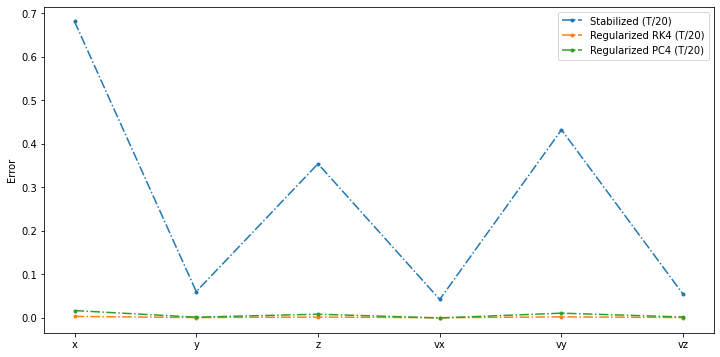

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(errors.loc['Stabilized (T/20)'], linestyle='-.', marker='.', label='Stabilized (T/20)')
plt.plot(errors.loc['Regularized RK4 (T/20)'], linestyle='-.', marker='.', label='Regularized RK4 (T/20)')
plt.plot(errors.loc['Regularized PC4 (T/20)'], linestyle='-.', marker='.', label='Regularized PC4 (T/20)')
plt.ylabel("Error")
plt.legend()
plt.show()

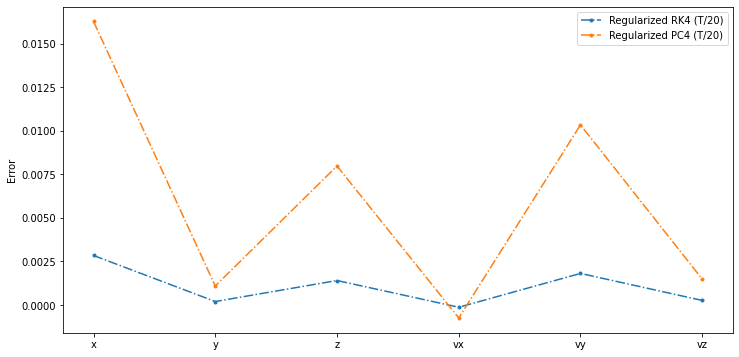

In [87]:
plt.figure(figsize=(12, 6))
#plt.plot(errors.loc['Stabilized (T/20)'], linestyle='-.', marker='.', label='Stabilized (T/20)')
plt.plot(errors.loc['Regularized RK4 (T/20)'], linestyle='-.', marker='.', label='Regularized RK4 (T/20)')
plt.plot(errors.loc['Regularized PC4 (T/20)'], linestyle='-.', marker='.', label='Regularized PC4 (T/20)')
plt.ylabel("Error")
plt.legend()
plt.show()

The errors for the RK4 are a bit better.

## Processing time comparison: RK4 vs PC4

Let's now run our program for several timesteps and see which method gives us the smaller processing times.

The time for a run can be seen attached to the bottom of the cell.

### PC4 processing times

In [94]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

u_pc = ABM(f, u0, sf, ds, s0)

In [95]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/100

u_pc = ABM(f, u0, sf, ds, s0)

In [99]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/1000

u_pc = ABM(f, u0, sf, ds, s0)

In [97]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/10000

u_pc = ABM(f, u0, sf, ds, s0)

In [98]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/100000

u_pc = ABM(f, u0, sf, ds, s0)

Therefore, we have, for the PC4, the following processing times:
- 9 ms ($\Delta t = T/20$)
- 20 ms ($\Delta t = T/100$)
- 139 ms ($\Delta t = T/1000$)
- 1.1 s ($\Delta t = T/10000$)
- 10.6 s ($\Delta t = T/100000$)

### RK4 Processing times

In [100]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/20

u = new_RK4(f, u0, sf, ds, s0)

In [101]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/100

u = new_RK4(f, u0, sf, ds, s0)

In [102]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/1000

u = new_RK4(f, u0, sf, ds, s0)

In [103]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/10000

u = new_RK4(f, u0, sf, ds, s0)

In [104]:
u_0 = u_vec
u_dot_0 = u_dot
t_0 = np.array([0])
H_0 = np.array([mu/(2*a)])

f = lambda s, u: u_ddot_regularized(s, u)

u0 = np.concatenate((u_0, u_dot_0, t_0, H_0))
s0 = 0
sf = 2*np.pi*(a/mu)**.5
ds = sf/100000

u = new_RK4(f, u0, sf, ds, s0)

Therefore, we have, for the RK4, the following processing times:
- 9 ms ($\Delta t = T/20$)
- 16 ms ($\Delta t = T/100$)
- 107 ms ($\Delta t = T/1000$)
- 0.892 s ($\Delta t = T/10000$)
- 9.02 s ($\Delta t = T/100000$)

### Conclusion

The RK4 was faster and had smaller errors.